# Transformer


#### In this notebook, we will implement a core engine of Tranformer.

#### Most of the parts are similar to the previous `makemore` notebooks - bigram/trigram/mlp.

#### I will go through (almost) every part of the transformer by investigating each operation by example, before making the whole thing into nicer format.


#### This notebook is based on a video by Andrej Karpathy (https://www.youtube.com/watch?v=kCc8FmEb1nY)


#### Instead of generating names, we will use one of Shakespeare's work, to generate more texts.


#### Let's download the dataset file.


In [1]:
import requests
import os

input_file_path = "shakespeare.txt"
if not os.path.exists(input_file_path):
    data_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    with open(input_file_path, "w") as f:
        f.write(requests.get(data_url).text)


In [2]:
with open("shakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()


#### The text is a script, which looks like this:


In [3]:
print(text[:200])


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


#### There are 65 different characters used in the entire dataset.

#### This will be our vocabulary list.


#### As before, we need encoding/decoding maps.


In [5]:
stoi = {ch: i for i, ch in enumerate(chars)}
itoi = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: "".join([itoi[i] for i in l])


In [6]:
print(encode("hi there"))


[46, 47, 1, 58, 46, 43, 56, 43]


In [7]:
print(decode(encode("hi there")))


hi there


#### (optional) there are other encoders. For example, using tiktoken (a Byte Pair Encoding (https://en.wikipedia.org/wiki/Byte_pair_encoding)):


In [8]:
import tiktoken

enc = tiktoken.get_encoding("gpt2")
enc.n_vocab


50257

#### There are 50257 vocabularies,


In [9]:
enc.encode("hi there")


[5303, 612]

In [10]:
enc.decode(enc.encode("hi there"))


'hi there'

#### Anyway, the engire dataset has 1.1M characters. Let's encode them.


In [11]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
data


tensor([18, 47, 56,  ..., 45,  8,  0])

In [12]:
data.shape


torch.Size([1115394])

In [13]:
data.dtype


torch.int64

#### Let's split train/validation data


In [14]:
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))
train_data = data[:n1]
val_data = data[n1:n2]
test_data = data[n2:]

#### We are going to work with chunks of data.

#### For examle, let's take first 9 characters.


In [15]:
block_size = 8
train_data[: block_size + 1]


tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

#### In the chunk of 9 characters, there are 8 examples. Why?


In [16]:
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(f"when input is {context} the target: {target}")


when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [17]:
[len(train_data), len(val_data), len(test_data)]


[892315, 111539, 111540]

#### Batch size is a dimension we need to consider.


#### Suppose the batch size is 4 and the block size is 8.


In [18]:
torch.manual_seed(42)
batch_size = 4
block_size = 8


#### Let's sample batches.

#### Let's get 4 (batch size) index vector, by sampling from 0, 1, ..., len(train_data) - 8 (block size). 

In [19]:
ix = torch.randint(len(train_data) - block_size, (batch_size,))
ix


tensor([700328,  21029,  90044, 831640])

#### Why? Because we are going to create (x,y) pair, by increasing the length of each x data points from 1 to 8 (block size) while keeping that of each y data point as 1.

In [20]:
train_data.shape

torch.Size([892315])

In [21]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y
    

xb, yb = get_batch("train")


In [22]:
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)


inputs:
torch.Size([4, 8])
tensor([[ 1, 58, 46, 43, 47, 56,  1, 39],
        [50, 43,  1, 63, 53, 59,  6,  1],
        [53, 59, 57,  1, 44, 50, 53, 61],
        [56, 45, 43, 42,  8,  0,  0, 24]])
targets:
torch.Size([4, 8])
tensor([[58, 46, 43, 47, 56,  1, 39, 45],
        [43,  1, 63, 53, 59,  6,  1, 39],
        [59, 57,  1, 44, 50, 53, 61, 43],
        [45, 43, 42,  8,  0,  0, 24, 17]])


#### In total, there are 32 examples. Let's see what's inside.


In [23]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, : t + 1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")


when input is [1] the target: 58
when input is [1, 58] the target: 46
when input is [1, 58, 46] the target: 43
when input is [1, 58, 46, 43] the target: 47
when input is [1, 58, 46, 43, 47] the target: 56
when input is [1, 58, 46, 43, 47, 56] the target: 1
when input is [1, 58, 46, 43, 47, 56, 1] the target: 39
when input is [1, 58, 46, 43, 47, 56, 1, 39] the target: 45
when input is [50] the target: 43
when input is [50, 43] the target: 1
when input is [50, 43, 1] the target: 63
when input is [50, 43, 1, 63] the target: 53
when input is [50, 43, 1, 63, 53] the target: 59
when input is [50, 43, 1, 63, 53, 59] the target: 6
when input is [50, 43, 1, 63, 53, 59, 6] the target: 1
when input is [50, 43, 1, 63, 53, 59, 6, 1] the target: 39
when input is [53] the target: 59
when input is [53, 59] the target: 57
when input is [53, 59, 57] the target: 1
when input is [53, 59, 57, 1] the target: 44
when input is [53, 59, 57, 1, 44] the target: 50
when input is [53, 59, 57, 1, 44, 50] the target

#### Now it is clear. 
- There are 4 batches.
- Each batch has 8 examples.
- Each example has different length of x: 1, ..., 8.
- Each example has the same length of y: 1.

#### Let's feed them into neural networks.


In [24]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(42)


#### Create a embedding table.

In [25]:
n_embd = 65
token_embedding_table = nn.Embedding(vocab_size, n_embd)
token_embedding_table

Embedding(65, 65)

#### It is a 65-by-65 matrix, and each row is a 65-dimensional real value vector. Take a look at the first three vectors.

<Axes: >

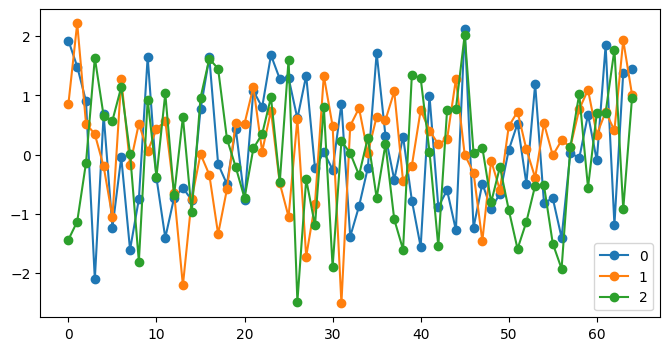

In [26]:
import pandas as pd
pd.DataFrame(token_embedding_table(torch.tensor([0,1,2])).detach().numpy().transpose()).plot(figsize=(8,4), marker='o')

#### What do we get if we apply this embedding our `xb`? Recall that `xb` has a dimension of (4,8). (batch size, block size).

In [27]:
(xb.shape, token_embedding_table)

(torch.Size([4, 8]), Embedding(65, 65))

In [28]:
token_embedding_table(xb).shape

torch.Size([4, 8, 65])

#### We get (4,8,32)! (batch size, block size, n_embd). 

#### That is, each element of `xb` is represented by 32-dimensional vector.

#### For simplicity, we will consider a bigram model - predicting the next character, given the previous one.

In [29]:
xb

tensor([[ 1, 58, 46, 43, 47, 56,  1, 39],
        [50, 43,  1, 63, 53, 59,  6,  1],
        [53, 59, 57,  1, 44, 50, 53, 61],
        [56, 45, 43, 42,  8,  0,  0, 24]])

In [30]:
yb

tensor([[58, 46, 43, 47, 56,  1, 39, 45],
        [43,  1, 63, 53, 59,  6,  1, 39],
        [59, 57,  1, 44, 50, 53, 61, 43],
        [45, 43, 42,  8,  0,  0, 24, 17]])

#### With NO training, we will get a random (bigram) model.

In [31]:
logits = token_embedding_table(xb)
logits.shape

torch.Size([4, 8, 65])

In [32]:
logits = logits[:, -1, :]
logits.shape

torch.Size([4, 65])

In [33]:
probs = F.softmax(logits, dim=-1)
probs.shape

torch.Size([4, 65])

#### Here are the 65 probabilities for each batch (there are 4 batches in total).

<Axes: >

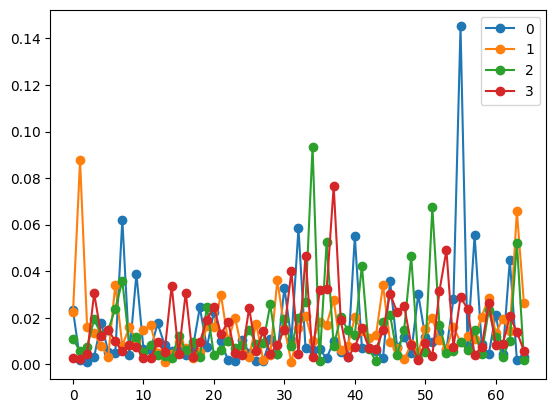

In [34]:
pd.DataFrame(probs.detach().numpy().transpose()).plot(marker='o') 

#### Sample a new token for each batch. 

In [35]:
idx_next = torch.multinomial(probs, num_samples=1)
idx_next

tensor([[59],
        [19],
        [ 3],
        [37]])

#### So this will be our new token for each batch. In terms of characters, they are:

In [36]:
decode(idx_next.view(-1).tolist())

'uG$Y'

#### Let's summarize what we've seen so far, and convert them into a class.

In [37]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets: dimension of (B,T)
        logits = self.token_embedding_table(idx)  # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) - beginning index

        for _ in range(max_new_tokens):
            # get predictions
            logits, loss = self(idx)  # logits: (B, T, C)

            # focus only on last time step
            logits = logits[:, -1, :]  # becomes (B, C)

            # get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)

            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

#### A few notes:

- `forward` method:
  - `nn.Embedding` is a lookup table for vocabulary.
  - We have to reshape logits and targets, such that it can be consumed for `cross_entropy`.
  - The method `forward` outputs logits (predicted probability) and loss (to be optimized).
  - We also need allow it to take `None` targets.
- `generate` method: this takes the last time-step, get probability from the embedding table, and sample.
  



#### OK, let's see it runs.

In [38]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape, loss)
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 65]) tensor(4.6320, grad_fn=<NllLossBackward0>)

LGP&A.V-mweqgZugEnL.VKPWmrUq

UV-!eUeTFDt-FaZJsFhHoByZfq Ij R,i
HDY 3nyM-mtZ:CZfLZ',oiJQ?Vgk$QXhAFp:


#### As expected, nothing but random. Let's train the model.


In [39]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [40]:
batch_size = 32
for steps in range(5000):
    xb, yb = get_batch("train")
    logis, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if (steps + 1) % 1000 == 0:
        print(steps, loss.item())

999 3.5610086917877197
1999 3.0242397785186768
2999 2.69878888130188
3999 2.650020122528076
4999 2.412374973297119


In [41]:
print(
    decode(
        m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[
            0
        ].tolist()
    )
)



YBYabthdKwoDbsou eeyes sOrwerapimoangad:
Twiveaves h sar f ashe M a

Se se, t-PEDzindomeavesh d madK


#### Now we have a slightly better model. This is still a bigram (only looking at a single character!). 

#### We need longer contexts.

#### Suppose we want to calculate mean of `x[b,0], ..., x[b,t]`: `x[b,t] = mean_{i<=t} * x[b,i]`.

#### Let's consider `C = 2` (previously it was 65.)

In [42]:
torch.manual_seed(42)
B, T, C = 4, 8, 2 # (batch, time, channels)
x = torch.randn(B, T, C)
x

tensor([[[ 1.9269,  1.4873],
         [ 0.9007, -2.1055],
         [ 0.6784, -1.2345],
         [-0.0431, -1.6047],
         [-0.7521,  1.6487],
         [-0.3925, -1.4036],
         [-0.7279, -0.5594],
         [-0.7688,  0.7624]],

        [[ 1.6423, -0.1596],
         [-0.4974,  0.4396],
         [-0.7581,  1.0783],
         [ 0.8008,  1.6806],
         [ 1.2791,  1.2964],
         [ 0.6105,  1.3347],
         [-0.2316,  0.0418],
         [-0.2516,  0.8599]],

        [[-1.3847, -0.8712],
         [-0.2234,  1.7174],
         [ 0.3189, -0.4245],
         [ 0.3057, -0.7746],
         [-1.5576,  0.9956],
         [-0.8798, -0.6011],
         [-1.2742,  2.1228],
         [-1.2347, -0.4879]],

        [[-0.9138, -0.6581],
         [ 0.0780,  0.5258],
         [-0.4880,  1.1914],
         [-0.8140, -0.7360],
         [-1.4032,  0.0360],
         [-0.0635,  0.6756],
         [-0.0978,  1.8446],
         [-1.1845,  1.3835]]])

In [43]:
xbow = torch.zeros ((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, : t+1] 
        print(xprev.shape)
        xbow[b,t] = torch.mean(xprev, 0)

torch.Size([1, 2])
torch.Size([2, 2])
torch.Size([3, 2])
torch.Size([4, 2])
torch.Size([5, 2])
torch.Size([6, 2])
torch.Size([7, 2])
torch.Size([8, 2])
torch.Size([1, 2])
torch.Size([2, 2])
torch.Size([3, 2])
torch.Size([4, 2])
torch.Size([5, 2])
torch.Size([6, 2])
torch.Size([7, 2])
torch.Size([8, 2])
torch.Size([1, 2])
torch.Size([2, 2])
torch.Size([3, 2])
torch.Size([4, 2])
torch.Size([5, 2])
torch.Size([6, 2])
torch.Size([7, 2])
torch.Size([8, 2])
torch.Size([1, 2])
torch.Size([2, 2])
torch.Size([3, 2])
torch.Size([4, 2])
torch.Size([5, 2])
torch.Size([6, 2])
torch.Size([7, 2])
torch.Size([8, 2])


#### Can we do this operation in other ways? 

#### Let's first take a look at the following matrix-matrix multiplication.

In [44]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3,2)).float()
c = a @ b
print(f'{a=}')
print(f'{b=}')
print(f'{c=}')

a=tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b=tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c=tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


#### Thus, using this trick, we can simplify the above calculation for `xbow`.

In [45]:
torch.tril(torch.ones(T,T))

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [46]:
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) @ (B, T, C) -----> (B, T, T) @ (B, T, C) -----> (B, T, C)
torch.allclose(xbow, xbow2)

True

#### Thus, `xbow` (brute-force mean) and `xbow2` (using lower tri-angular matrix) are the same.

#### Another version, but equivalent one, would be using `-inf` and `softmax`. 

In [47]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

#### Thus, `xbow` (brute-force mean) and `xbow3` (lower-triangular and maskied fill by -inf trick) are the same.

#### Remarks:
- `wei = torch.zeros((T,T))`: in this line, we set all the values of all the tokens to be zero in the beginning, but these tokens will start looking at each other, and some tokens find other tokens more interesting. ("affinity" that Andrej called.)
- `wei = wei.masked_fill(tril==0, float('-inf'))`: this line makes sure that the future cannot communicate with the past ("no look ahead")
- We don't need to set `wei` uniform. Remember that every token takes two vectors.
- Query: "What am I looking for"?
- Key: "What do I contain?"
- A dot product of Q and K becomes `wei`. 

#### Let's design a single head  of self-attention.

#### Here is sample data. `C` is set to be `32`, going forward.

In [48]:
torch.manual_seed(42)
B, T, C = 4, 8, 32 # (batch, time, channels)
x = torch.randn(B, T, C)

#### A new parameter for the head: `head_size`. We set it to be 16 for now.

In [49]:
head_size = 16

#### What is `head_size`? It is the out-dimension for linear modules.

#### Initialize linear modules for query and key

In [50]:
query = nn.Linear(C, head_size, bias=False)
key = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
query, key, value

(Linear(in_features=32, out_features=16, bias=False),
 Linear(in_features=32, out_features=16, bias=False),
 Linear(in_features=32, out_features=16, bias=False))

#### If we forward this Linear module on x, then we get `[B, T, head_size]` matrix.

In [51]:
k = key(x) # (B, T, head_size) = (4, 8, 16)
q = query(x) # (B, T, head_size) = (4, 8, 16)
v = value(x) # (B, T, head_size) = (4, 8, 16)
x.shape, k.shape, q.shape, v.shape

(torch.Size([4, 8, 32]),
 torch.Size([4, 8, 16]),
 torch.Size([4, 8, 16]),
 torch.Size([4, 8, 16]))

#### So far, no communication between queries and keys. But if we do a dot-product, 

In [52]:
k.transpose(-2,-1).shape

torch.Size([4, 16, 8])

In [53]:
wei = q @ k.transpose(-2,-1) # [4, 8, 16] @ [4, 16, 8] ----> [4, 8, 8]
wei.shape

torch.Size([4, 8, 8])

#### This is our initialized `wei` (as opposed to all zeros). If we apply the same operations as before,

In [54]:
tril = torch.tril(torch.ones(T,T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
out = wei @ v
out.shape

torch.Size([4, 8, 16])

#### As seen from the below, every single batch element has a different wei value.

#### First batch

In [55]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1236, 0.8764, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1274, 0.0991, 0.7735, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1018, 0.5800, 0.0192, 0.2989, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1007, 0.3380, 0.2122, 0.2630, 0.0862, 0.0000, 0.0000, 0.0000],
        [0.2143, 0.2812, 0.2176, 0.1199, 0.0668, 0.1003, 0.0000, 0.0000],
        [0.1067, 0.1181, 0.0842, 0.1078, 0.0097, 0.5417, 0.0319, 0.0000],
        [0.0138, 0.0266, 0.0078, 0.0239, 0.6866, 0.0381, 0.1671, 0.0361]],
       grad_fn=<SelectBackward0>)

#### ...second batch 

In [56]:
wei[1]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8200, 0.1800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0583, 0.7433, 0.1984, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0555, 0.8605, 0.0176, 0.0665, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2292, 0.1540, 0.4331, 0.0279, 0.1558, 0.0000, 0.0000, 0.0000],
        [0.2688, 0.0805, 0.1100, 0.0861, 0.1927, 0.2620, 0.0000, 0.0000],
        [0.0663, 0.3156, 0.0614, 0.3570, 0.0505, 0.0579, 0.0914, 0.0000],
        [0.0361, 0.0506, 0.3941, 0.0328, 0.2050, 0.1358, 0.0200, 0.1256]],
       grad_fn=<SelectBackward0>)

#### Note that the reason why it is "self-attention" is because key, query, and value are all from the same source, x. (But there could be other situations. For example, if queries are from x, but keys and values are from external sources, then it will be "cross-attention".)

#### We would like to make some changes in the code:

1. We introduce a new variable `n_embd`, the dimension of embedding vectors: 
  - `self.token_embedding_table = nn.Embedding(vocab_size, n_embd)`
2. We need a linear layer to convert token embedding into logits (for `vocab_size`).
  - `self.lm_head = nn.Linear(n.embd, vocab_size)`
3. We need a positional embedding table (and incorporate it into the encoding.). This informs our model about the order of sequences.
  - `self.position_embedding_table = nn.Embedding(block_size, n_embd)`

#### We wrap up what we got. We create a class for single head - `class Head(nn.Module)`.
- in `init`, we define linear layers for key, query, and value.
- in `forward`: we create the attention score ("affinity")

In [57]:
n_embd = 32

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear (n_embd, head_size, bias=False)
        self.query = nn.Linear (n_embd, head_size, bias=False)
        self.value = nn.Linear (n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        # dot (k, q)
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * C ** (-0.5)  # dot-product with normalization
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # (B,T,T)
        wei = F.softmax(wei, dim=-1)

        # aggregate the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out   


#### We will use this `Head` class in our bigram model.

In [58]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.sa_head = Head(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        # idx and targets: dimension of (B,T)
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T)) #, device=device))
        x = tok_emb + pos_emb  # inject the information for the order of sequences.
        x = self.sa_head(x)  # single head
        logits = self.lm_head(x)  # Linear transform of head to vocab_size
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T)
        for _ in range(max_new_tokens):

            # We will use the last block_size tokens
            idx_cond = idx[:, -block_size:] 

            # get predictions
            logits, loss = self(idx_cond)  # logits: (B, T, C)

            # focus only on last time step
            logits = logits[:, -1, :]  # becomes (B, C)

            # get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)

            # sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1)

            # append
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

#### Let's train this.

In [59]:
m = BigramLanguageModel(vocab_size)

In [60]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [61]:
batch_size = 32
for steps in range(5000):
    xb, yb = get_batch("train")
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if (steps + 1) % 1000 == 0:
        print(steps, loss.item())

999 2.510788917541504
1999 2.3954503536224365
2999 2.457631826400757
3999 2.399949789047241
4999 2.388049364089966


In [62]:
print(
    decode(
        m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[
            0
        ].tolist()
    )
)



Tithe swoonchul wnery a: smy winesinon wite,
An V he, gel,

DINGUSUETCESR: nd ik. Rokerecel, at'stu 


#### Great, now we see a lot better result.

#### Here is a simplified architecture for decoder-only transformer.

- `positional embedding`
- `blocks`, where each block is:
  - `layer norm`
  - `multi-head attention`
    - concatenate `head`s and `projection` to (`n_embd` dim)
  - `add`
  - `layer norm`
  - `feed forward`
    - `linear`
    - `relu`
    - `linear`
  - `add`
- `layer norm`
- `linear`
- `softmax`



#### Define parameters

In [64]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
lr = 1e-3
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4

#### The class `Head` we built doesn't change. Instead, we need a class for multi-head.

In [65]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear (n_embd, head_size, bias=False)
        self.query = nn.Linear (n_embd, head_size, bias=False)
        self.value = nn.Linear (n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape

        # dot (k, q)
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * C ** (-0.5)  # dot-product with normalization
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # (B,T,T)
        wei = F.softmax(wei, dim=-1)

        # aggregate the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out   


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

#### We didn't implement the `feed forward` part yet.

In [66]:

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)

#### Using `MultiHeadAttention` and `FeedForward`, we implement a single `Block` class.

In [67]:

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


#### Incorporating this `Block` class, we revise our bigram model class (this part is exactly the same as the last part of Andrej's notebook.)

In [68]:
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        B, T, C = tok_emb.shape
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)

        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

#### OK, let's train the model.

In [69]:
model = BigramLanguageModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % 100 == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 4.3214, val loss 4.3170
step 100: train loss 2.6514, val loss 2.6744
step 200: train loss 2.5040, val loss 2.5352
step 300: train loss 2.4155, val loss 2.4510
step 400: train loss 2.3548, val loss 2.3902
step 500: train loss 2.3054, val loss 2.3582
step 600: train loss 2.2679, val loss 2.3161
step 700: train loss 2.2112, val loss 2.2534
step 800: train loss 2.1817, val loss 2.2157
step 900: train loss 2.1378, val loss 2.1971
step 1000: train loss 2.1059, val loss 2.1670
step 1100: train loss 2.0869, val loss 2.1261
step 1200: train loss 2.0651, val loss 2.1324
step 1300: train loss 2.0201, val loss 2.0888
step 1400: train loss 2.0040, val loss 2.0623
step 1500: train loss 1.9844, val loss 2.0367
step 1600: train loss 1.9651, val loss 2.0102
step 1700: train loss 1.9394, val loss 2.0139
step 1800: train loss 1.9214, val loss 2.0101
step 1900: train loss 1.9021, val loss 1.9952
step 2000: train loss 1.9050, val loss 1.9791
step 2100: train loss 1.8696, val loss 1.9544


#### Let's make more (next 2000 characters) work!

In [70]:
context = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


I which I long them-fares here surked,
Whil with pursection my faid do.
Shephered' and my stande couse.
All, I you dreece! the nature! If 'He even grong mise's suck which you more
You evens as thou somet. I do hear,
That at untery that longs doin the,
For my uncred-hen arming to the conked.
vire some, becurie 'tis queel!

QUEEN VI ELIVA:
Yill greaste at same insomest my my diest,
That's but comelful; she appayon'd take to Musire herse;
Too did and was for undom to by do eath that Edvil
He lornk to end not one breada master: hold,
inle your shighter thee of right
Hast onchemes mytredom of ac his dardient him.

AUTOLUMBERLA:
It lord?
But SBoht that you unsues I dare,
Hut stren tongentord of him distrain.
Thou do to his it; I to I know out to his lose grast,
Whom shame do lady the comegare. Where Cath wive, your prince the is incice
Look him, if with I will love!

FLURIAE:
And poweel tery
My death.

YORK:
Would that wengeft instas, reci' and so name,
I hom come, my this'd becate a he had

#### That's it.

#### In summary:
- The main purpose of this notebook was to understand the detail of the core structure and operations of transformer.
- We built a simplified decoder-only transformer from scratch.
- The trained transformer was able to generate pretty realistic work.